In [205]:
import pandas as pd 
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
import numpy as np 
import pybaseball as pyb 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import matplotlib.patches as mpatches

from scipy.spatial import ConvexHull


import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO

In [3]:
#Imoport 2023 data 
data2023 = pyb.statcast("2023-03-30","2023-11-10")

This is a large query, it may take a moment to complete


100%|██████████| 226/226 [00:29<00:00,  7.61it/s]
/Users/EmilioMartinez_1/Library/Python/3.9/lib/python/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


I am going to just get a df where all balls are put into play, and since i will filter by 90th ev then bunts shouldnt be an issue. I am going to decide how to visualize 90th percent ev.
Then, I will use a full df to find swing and miss outside the Nitro Zone. 

In [4]:
#Type = X is going to denote a ball in play

BIP = data2023.copy()
BIP = BIP[BIP['type'] == 'X']
BIP.head() #check to see if the first few entreis only have 'X' in type



,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
140,FF,2023-11-01,95.6,-0.66,6.25,"Sborz, Josh",682998,622250,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,11,Corbin Carroll pops out to catcher Jonah Heim ...,W,L,R,AZ,TEX,X,2,popup,1,0,2023,-0.43,1.64,-0.17,3.64,<NA>,<NA>,<NA>,1,9,Bot,124.49,219.21,<NA>,<NA>,641680,<NA>,<NA>,2.251862,-139.089664,-4.88954,-6.09213,32.736235,-10.02343,3.15,1.48,43,88.8,84,94.7,2409,5.9,748534,622250,641680,663993,543760,673962,608369,694497,665750,608671,54.6,0.001,0.0,0.0,1,0,0,3,76,2,4-Seam Fastball,0,5,0,5,5,0,0,5,Standard,Standard,208,-0.002,-0.194
194,ST,2023-11-01,85.5,-3.55,4.56,"Sewald, Paul",608369,623149,single,hit_into_play,<NA>,<NA>,<NA>,<NA>,8,Corey Seager singles on a ground ball to third...,W,L,R,AZ,TEX,X,5,ground_ball,0,1,2023,1.12,0.51,-0.17,1.69,<NA>,<NA>,<NA>,2,9,Top,104.04,171.34,<NA>,<NA>,672515,<NA>,<NA>,5.710078,-124.4077,-1.452578,10.236182,28.165953,-26.802876,3.48,1.53,1,65.3,-50,85.0,2644,6.3,748534,623149,672515,572233,606466,656896,672695,666971,677950,682998,54.21,0.271,0.257,0.9,1,1,0,2,73,2,Sweeper,0,5,5,0,5,0,5,0,Infield shade,Standard,97,0.0,0.15
207,FF,2023-11-01,92.5,-3.6,4.46,"Sewald, Paul",543760,623149,home_run,hit_into_play,<NA>,<NA>,<NA>,<NA>,3,Marcus Semien homers (2) on a fly ball to left...,W,R,R,AZ,TEX,X,<NA>,fly_ball,0,1,2023,-0.78,1.07,0.39,2.94,641680,<NA>,<NA>,2,9,Top,65.94,46.11,<NA>,<NA>,672515,<NA>,<NA>,11.839322,-134.261415,-0.393,-11.945114,29.053927,-19.349455,3.32,1.57,406,99.3,25,92.4,2613,6.4,748534,623149,672515,572233,606466,656896,672695,666971,677950,682998,54.14,0.449,0.665,2.0,1,0,3,6,72,2,4-Seam Fastball,0,3,3,0,5,0,5,0,Standard,Standard,231,-0.026,1.793
213,FF,2023-11-01,91.7,-3.65,4.44,"Sewald, Paul",608671,623149,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,3,"Travis Jankowski grounds out, shortstop Gerald...",W,L,R,AZ,TEX,X,6,ground_ball,0,0,2023,-0.78,1.15,0.28,2.97,641680,<NA>,<NA>,1,9,Top,114.56,155.93,<NA>,<NA>,672515,<NA>,<NA>,11.595702,-133.065987,-0.301304,-11.775413,29.496875,-18.680691,3.53,1.72,18,83.4,-7,91.5,2558,6.4,748534,623149,672515,572233,606466,656896,672695,666971,677950,682998,54.1,0.146,0.142,0.0,1,0,0,2,71,1,4-Seam Fastball,0,3,3,0,3,0,3,0,Strategic,Standard,241,0.01,-0.351
245,FF,2023-11-01,92.9,-3.69,4.48,"Sewald, Paul",641680,623149,single,hit_into_play,<NA>,<NA>,<NA>,<NA>,4,Jonah Heim singles on a sharp ground ball to c...,W,L,R,AZ,TEX,X,8,ground_ball,0,0,2023,-0.87,1.07,-0.73,2.6,<NA>,673962,663993,0,9,Top,147.3,90.95,<NA>,<NA>,672515,<NA>,<NA>,9.471365,-134.916286,-1.28061,-12.852248,32.157472,-19.153033,3.58,1.72,47,103.9,-1,92.5,2494,6.4,748534,623149,672515,572233,606466,656896,672695,666971,677950,682998,54.13,0.44,0.396,0.9,1,1,0,4,69,1,4-Seam Fastball,0,1,1,0,3,0,3,0,Standard,Standard,238,-0.087,0.938


First, we are going to use the reverse_lookup function in pybaseball to get the player ids to names 

In [5]:
#get all unique batter ids in my df
unique_ids = BIP['batter'].unique()
#use the pybaseball reverse_lookup function to find all names for the batters
player_info = pyb.playerid_reverse_lookup(unique_ids, key_type='mlbam')


In [217]:
#create df that has all batter names and their id
hitter_names = player_info[['key_mlbam', 'name_first', 'name_last']]

# Make a column where the full name is "First Last"
hitter_names['full_name'] = hitter_names['name_first'].str.capitalize() + ' ' + hitter_names['name_last'].str.capitalize()

hitter_names.rename(columns={'key_mlbam': 'batter'}, inplace=True)
BIP_new = BIP.merge(hitter_names[['batter', 'full_name']], on='batter', how='left')
BIP_new.head()



/var/folders/jn/wfpqyzfx0t7cprw54pg29r1h0000gn/T/ipykernel_84705/2057833549.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hitter_names['full_name'] = hitter_names['name_first'].str.capitalize() + ' ' + hitter_names['name_last'].str.capitalize()
/var/folders/jn/wfpqyzfx0t7cprw54pg29r1h0000gn/T/ipykernel_84705/2057833549.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hitter_names.rename(columns={'key_mlbam': 'batter'}, inplace=True)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,full_name
0,FF,2023-11-01,95.6,-0.66,6.25,"Sborz, Josh",682998,622250,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,11,Corbin Carroll pops out to catcher Jonah Heim ...,W,L,R,AZ,TEX,X,2,popup,1,0,2023,-0.43,1.64,-0.17,3.64,<NA>,<NA>,<NA>,1,9,Bot,124.49,219.21,<NA>,<NA>,641680,<NA>,<NA>,2.251862,-139.089664,-4.88954,-6.09213,32.736235,-10.02343,3.15,1.48,43,88.8,84,94.7,2409,5.9,748534,622250,641680,663993,543760,673962,608369,694497,665750,608671,54.6,0.001,0.0,0.0,1,0,0,3,76,2,4-Seam Fastball,0,5,0,5,5,0,0,5,Standard,Standard,208,-0.002,-0.194,Corbin Carroll
1,ST,2023-11-01,85.5,-3.55,4.56,"Sewald, Paul",608369,623149,single,hit_into_play,<NA>,<NA>,<NA>,<NA>,8,Corey Seager singles on a ground ball to third...,W,L,R,AZ,TEX,X,5,ground_ball,0,1,2023,1.12,0.51,-0.17,1.69,<NA>,<NA>,<NA>,2,9,Top,104.04,171.34,<NA>,<NA>,672515,<NA>,<NA>,5.710078,-124.4077,-1.452578,10.236182,28.165953,-26.802876,3.48,1.53,1,65.3,-50,85.0,2644,6.3,748534,623149,672515,572233,606466,656896,672695,666971,677950,682998,54.21,0.271,0.257,0.9,1,1,0,2,73,2,Sweeper,0,5,5,0,5,0,5,0,Infield shade,Standard,97,0.0,0.15,Corey Seager
2,FF,2023-11-01,92.5,-3.6,4.46,"Sewald, Paul",543760,623149,home_run,hit_into_play,<NA>,<NA>,<NA>,<NA>,3,Marcus Semien homers (2) on a fly ball to left...,W,R,R,AZ,TEX,X,<NA>,fly_ball,0,1,2023,-0.78,1.07,0.39,2.94,641680,<NA>,<NA>,2,9,Top,65.94,46.11,<NA>,<NA>,672515,<NA>,<NA>,11.839322,-134.261415,-0.393,-11.945114,29.053927,-19.349455,3.32,1.57,406,99.3,25,92.4,2613,6.4,748534,623149,672515,572233,606466,656896,672695,666971,677950,682998,54.14,0.449,0.665,2.0,1,0,3,6,72,2,4-Seam Fastball,0,3,3,0,5,0,5,0,Standard,Standard,231,-0.026,1.793,Marcus Semien
3,FF,2023-11-01,91.7,-3.65,4.44,"Sewald, Paul",608671,623149,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,3,"Travis Jankowski grounds out, shortstop Gerald...",W,L,R,AZ,TEX,X,6,ground_ball,0,0,2023,-0.78,1.15,0.28,2.97,641680,<NA>,<NA>,1,9,Top,114.56,155.93,<NA>,<NA>,672515,<NA>,<NA>,11.595702,-133.065987,-0.301304,-11.775413,29.496875,-18.680691,3.53,1.72,18,83.4,-7,91.5,2558,6.4,748534,623149,672515,572233,606466,656896,672695,666971,677950,682998,54.1,0.146,0.142,0.0,1,0,0,2,71,1,4-Seam Fastball,0,3,3,0,3,0,3,0,Strategic,Standard,241,0.01,-0.351,Travis Jankowski
4,FF,2023-11-01,92.9,-3.69,4.48,"Sewald, Paul",641680,623149,single,hit_into_play,<NA>,<NA>,<NA>,<NA>,4,Jonah Heim singles on a sharp ground ball to c...,W,L,R,AZ,TEX,X,8,ground_ball,0,0,2023,-0.87,1.07,-0.73,2.6,<NA>,673962,663993,0,9,Top,147.3,90.95,<NA>,<NA>,672515,<NA>,<NA>,9.471365,-134.916286,-1.28061,-12.852248,32.157472,-19.153033,3.58,1.72,47,103.9,-1,92.5,2494,6.4,748534,623149,672515,572233,606466,656896,672695,666971,677950,682998,54.13,0.44,0.396,0.9,1,1,0,4,69,1,4-Seam Fastball,0,1,1,0,3,0,3,0,Standard,Standard,238,-0.087,0.938,Jonah Heim


# Get mlb hitter headshots


In [ ]:
'''
#create list of unique batter ids in df 
player_ids = BIP_new['batter'].unique().tolist()


for player_id in player_ids:

     # Replace 'URL_HERE' with the actual URL of the MLB player's profile page
     url = (f'https://www.mlb.com/player/{player_id}')

     # Send a request to the website
     response = requests.get(url)
     
     if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract the image URL if available
        image_tag = soup.select_one('.player-headshot')
        image_url = image_tag['src'] if image_tag else None

        # Download the image if it exists
        if image_url:
            image_response = requests.get(image_url)
            image = Image.open(BytesIO(image_response.content))
            image.save(f"/Volumes/Emilio's Ex/code/Data/mlb_headshots/{player_id}.jpg")            
            print(f'Image downloaded for player ID: {player_id}')
        else:
            image = None
            print(f'No image found for player ID: {player_id}')
'''

# Get mlb pitcher headshots


In [226]:
#create list of unique batter ids in df 
pitcher_ids = data2023['pitcher'].unique().tolist()


for pitcher_id in pitcher_ids:

     # Replace 'URL_HERE' with the actual URL of the MLB player's profile page
     url = (f'https://www.mlb.com/player/{pitcher_id}')

     # Send a request to the website
     response = requests.get(url)
     
     if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract the image URL if available
        image_tag = soup.select_one('.player-headshot')
        image_url = image_tag['src'] if image_tag else None

        # Download the image if it exists
        if image_url:
            image_response = requests.get(image_url)
            image = Image.open(BytesIO(image_response.content))
            image.save(f"/Volumes/Emilio's Ex/code/Data/mlb_headshots/{pitcher_id}.jpg")            
            print(f'Image downloaded for player ID: {pitcher_id}')
        else:
            image = None
            print(f'No image found for player ID: {pitcher_id}')


Image downloaded for player ID: 622250
Image downloaded for player ID: 623149
Image downloaded for player ID: 656464
Image downloaded for player ID: 547973
Image downloaded for player ID: 668678
Image downloaded for player ID: 543135
Image downloaded for player ID: 600917
Image downloaded for player ID: 519293
Image downloaded for player ID: 685314
Image downloaded for player ID: 669194
Image downloaded for player ID: 608717
Image downloaded for player ID: 656271
Image downloaded for player ID: 674003
Image downloaded for player ID: 641540
Image downloaded for player ID: 571760
Image downloaded for player ID: 666818
Image downloaded for player ID: 669459
Image downloaded for player ID: 612434
Image downloaded for player ID: 573009
Image downloaded for player ID: 592351
Image downloaded for player ID: 694297
Image downloaded for player ID: 453286
Image downloaded for player ID: 527048
Image downloaded for player ID: 518876
Image downloaded for player ID: 656756
Image downloaded for play

CLEAN UP DF NAMES, create new ones for pitcher, map colors from statcast onto here, add colors to both pitcher and hitter plots..

Run download for mlb pitcher ids fuck it

# Plotting


In [271]:
#define a player name 
player = 'Jorge Soler'

# Find the batter number for the player with the full name from the player variable
player_batter_number = BIP_new.loc[BIP_new['full_name'] == player, 'batter'].values

# player_batter_number will be an array of all the matching 'batter' values
# Take the first value since we only need one... this will be used to pull the image later
player_batter_number = player_batter_number[0]


#create new df that only includes the player data
x = BIP_new[BIP_new['full_name'] == player]

#filter out 95th percentile BBE
percentile_95 = x['launch_speed'].quantile(0.95)

# Filter the DataFrame for pitches above the 90th percentile
filtered_df = x[x['launch_speed'] >= percentile_95]


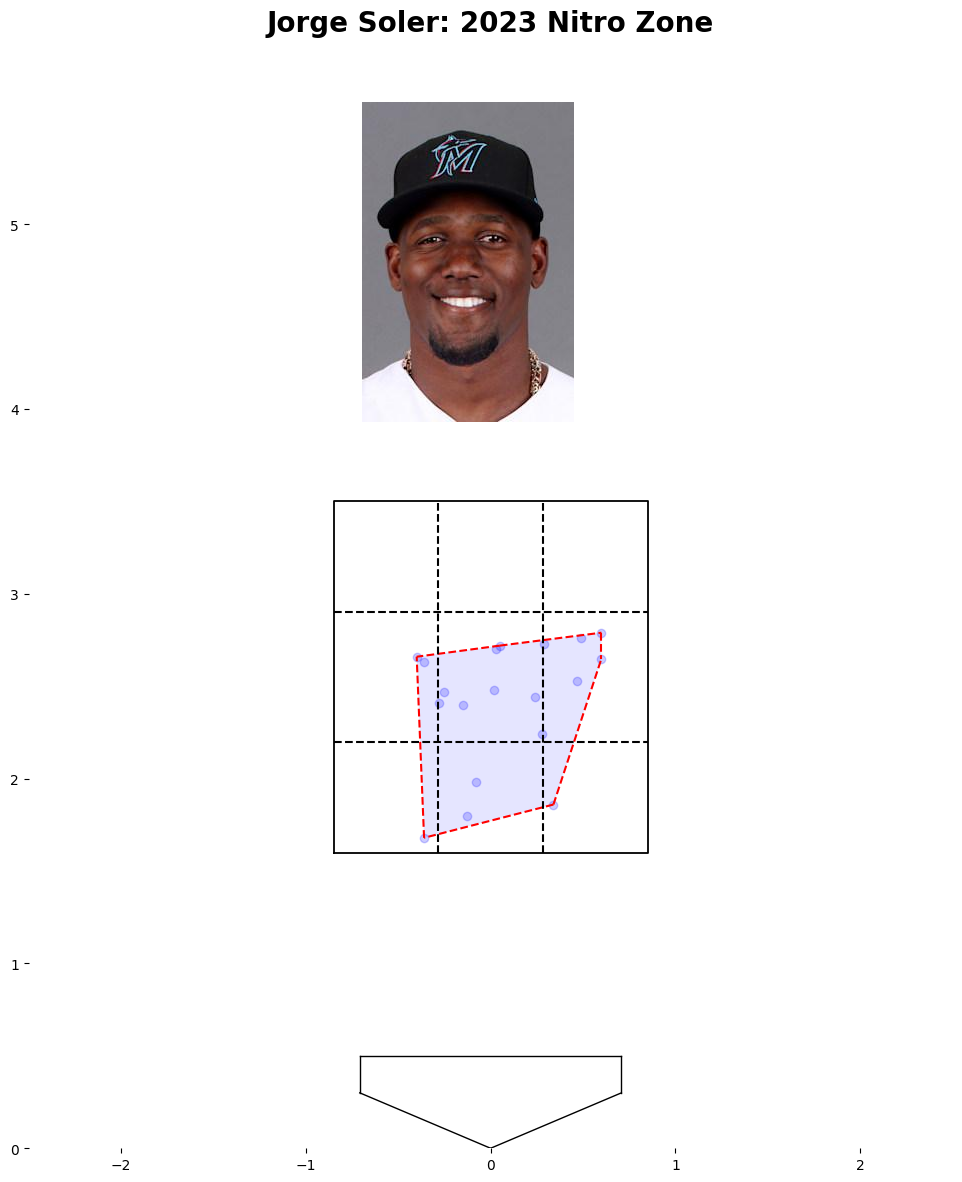

In [272]:
plt.figure(figsize=(12, 12))

# Load the image
image_path = (f"/Volumes/Emilio's Ex/code/Data/mlb_headshots/{player_batter_number}.jpg")  
img = mpimg.imread(image_path)

# Add the image under the title

plt.figimage(img, xo=fig.bbox.xmax / 2.55 - img.shape[1] / 7, yo=fig.bbox.ymax - img.shape[0] + 80, zorder=1) # The parameters are [left, bottom, width, height] in pixels



plt.scatter(filtered_df['plate_x'], filtered_df['plate_z'], c='blue', alpha=0.2) # add label if you want legend

# Convex Hull
points = filtered_df[['plate_x', 'plate_z']].values
if len(points) >= 3:  # Convex hull requires at least 3 points
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'r--')
    
    # Filling the convex hull
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.1)


# DEFINE STRIKE ZONE
strike_zone = pd.DataFrame({
  'PlateLocSide': [-0.85, -0.85, 0.85, 0.85, -0.85],
  'PlateLocHeight': [1.6, 3.5, 3.5, 1.6, 1.6]
})

# Add strike zone
plt.plot(strike_zone['PlateLocSide'], strike_zone['PlateLocHeight'], color='black', linewidth=1.3)

# Add dashed lines
plt.plot([-0.2833333, -0.2833333], [1.6, 3.5], color='black', linestyle='dashed')
plt.plot([0.2833333, 0.2833333], [1.6, 3.5], color='black', linestyle='dashed')
plt.plot([-0.85, 0.85], [2.2, 2.2], color='black', linestyle='dashed')
plt.plot([-0.85, 0.85], [2.9, 2.9], color='black', linestyle='dashed')

# Add home plate
plt.plot([-0.708, 0.708], [0.5, 0.5], color='black', linewidth=1)
plt.plot([-0.708, -0.708], [0.5, 0.3], color='black', linewidth=1)
plt.plot([-0.708, 0], [0.3, 0], color='black', linewidth=1)
plt.plot([0, 0.708], [0, 0.3], color='black', linewidth=1)
plt.plot([0.708, 0.708], [0.3, 0.5], color='black', linewidth=1)

# Removing gridlines , border, and ticks
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
#plt.xticks([])
#plt.yticks([])

# Labels and Title
#plt.xlabel('Plate Side (ft)')
#plt.ylabel('Plate Height (ft)')
plt.title(f'{player}: 2023 Nitro Zone',y=1.2, fontsize = 20, fontweight = 'bold')

# Set limits and aspect ratio
plt.xlim(-2.5, 2.5)
plt.ylim(0, 5)
plt.gca().set_aspect('equal')

# Placing the legend outside the plot
#plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

plt.show()

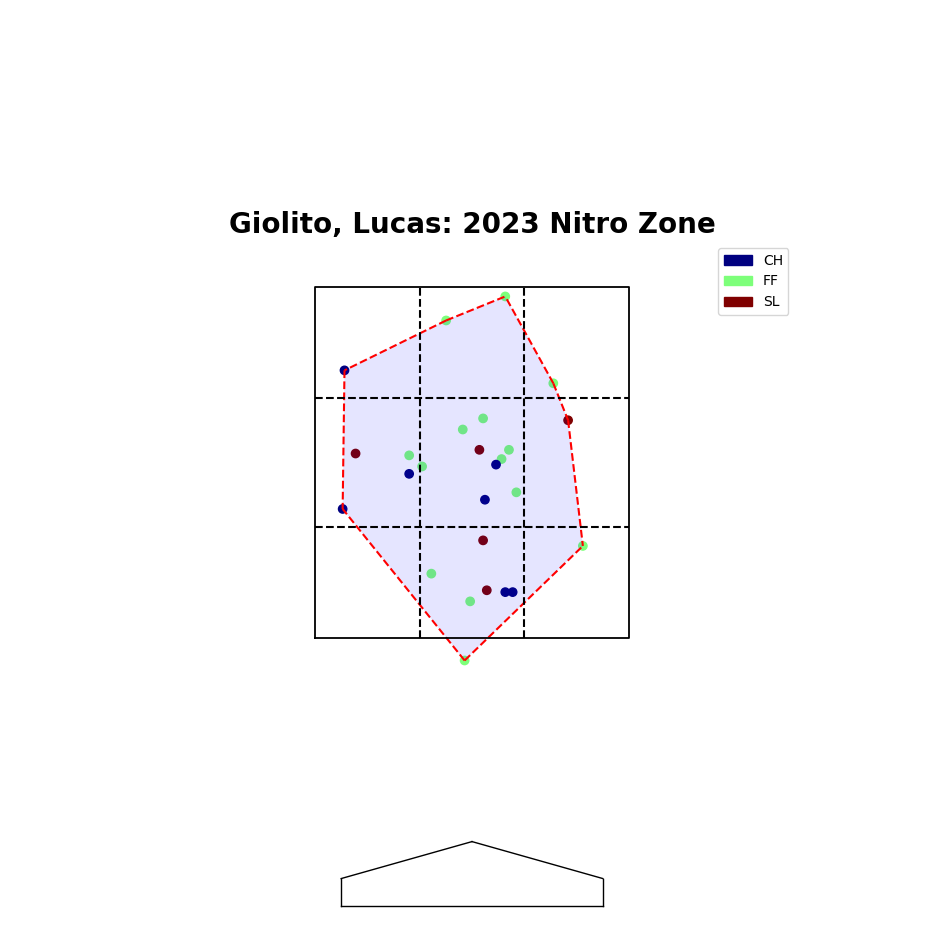

In [245]:

#define a player name 
pitcher = 'Giolito, Lucas'


'''
# Find the batter number for the player with the full name 'Christian Walker'
player_pitcher_number = BIP_new.loc[BIP_new['player_name'] == pitcher, 'pitcher'].values

# Player_batter_number will be an array of all the matching 'batter' values
# Take the first value since we only need one... this will be used to pull the image later
player_batter_number = player_batter_number[0]
'''

#create new df that only includes the player data
x1 = BIP_new[BIP_new['player_name'] == pitcher]


#filter out 95th percentile BBE
percentile_951 = x1['launch_speed'].quantile(0.95)

# Filter the DataFrame for pitches above the 90th percentile
filtered_df_2 = x1[x1['launch_speed'] >= percentile_951]

# Unique pitch types and assign a color to each
unique_pitch_types = filtered_df_2['pitch_type'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_pitch_types)))
color_map = dict(zip(unique_pitch_types, colors))

# Map each pitch type in your DataFrame to a color
color_for_plot = filtered_df_2['pitch_type'].map(color_map)

plt.figure(figsize=(12, 12))
'''
# Load the image
image_path = (f"/Volumes/Emilio's Ex/code/Data/mlb_headshots/{player_batter_number}.jpg")  # Replace with your image path
img = mpimg.imread(image_path)

# Add the image under the title, adjusting the extent as needed
# The parameters are [left, bottom, width, height] in pixels
plt.figimage(img, xo=fig.bbox.xmax / 2.55 - img.shape[1] / 7, yo=fig.bbox.ymax - img.shape[0] + 80, zorder=1)
'''


plt.scatter(filtered_df_2['plate_x'], filtered_df_2['plate_z'], c=color_for_plot, alpha=1, label = 'Pitch') # add label if you want legend

# Convex Hull
points = filtered_df_2[['plate_x', 'plate_z']].values
if len(points) >= 3:  # Convex hull requires at least 3 points
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'r--')
    
    # Filling the convex hull
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=.1)


# DEFINE STRIKE ZONE
strike_zone = pd.DataFrame({
  'PlateLocSide': [-0.85, -0.85, 0.85, 0.85, -0.85],
  'PlateLocHeight': [1.6, 3.5, 3.5, 1.6, 1.6]
})

# Add strike zone
plt.plot(strike_zone['PlateLocSide'], strike_zone['PlateLocHeight'], color='black', linewidth=1.3)

# Add dashed lines
plt.plot([-0.2833333, -0.2833333], [1.6, 3.5], color='black', linestyle='dashed')
plt.plot([0.2833333, 0.2833333], [1.6, 3.5], color='black', linestyle='dashed')
plt.plot([-0.85, 0.85], [2.2, 2.2], color='black', linestyle='dashed')
plt.plot([-0.85, 0.85], [2.9, 2.9], color='black', linestyle='dashed')

# Add home plate
plt.plot([-0.708, 0.708], [0.15, 0.15], color='black', linewidth=1)
plt.plot([-0.708, -0.708], [0.15, 0.3], color='black', linewidth=1)
plt.plot([-0.708, 0], [0.3, 0.5], color='black', linewidth=1)
plt.plot([0, 0.708], [0.5, 0.3], color='black', linewidth=1)
plt.plot([0.708, 0.708], [0.3, 0.15], color='black', linewidth=1)

# Removing gridlines , border, and ticks
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

# Labels and Title
#plt.xlabel('Plate Side (ft)')
#plt.ylabel('Plate Height (ft)')
plt.title(f'{pitcher}: 2023 Nitro Zone',y=.75, fontsize = 20, fontweight = 'bold')

# Set limits and aspect ratio
plt.xlim(-2.5, 2.5)
plt.ylim(0, 5)
plt.gca().set_aspect('equal')

# Placing the legend outside the plot
#plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
legend_handles = [mpatches.Patch(color=color_map[type], label=type) for type in unique_pitch_types]
plt.legend(loc='upper right', bbox_to_anchor=(.85, .75),handles=legend_handles)

plt.show()